## Import required libraries

In [1]:
#needed for cloudX lab
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
spark = SQLContext(sc)

In [2]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
import math
from math import sqrt
from pyspark.sql.functions import *
import warnings
warnings.filterwarnings('ignore')
from matplotlib import *
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from pyspark.sql.types import *
from pyspark.sql import Row
import seaborn as sns

## Import Datasets

In [3]:
#complete_ratings_raw_data = sc.textFile('C:/Users/nka21/Documents/GL/Lessons/Lesson_8_recommendation_systems/ratings.csv')

In [4]:
complete_ratings_raw_data = sc.textFile('hdfs://ip-172-31-53-48.ec2.internal:8020/data/greatlearning/RS/dataset/ratings.csv')

In [5]:
type(complete_ratings_raw_data)

pyspark.rdd.RDD

In [6]:
complete_ratings_raw_data.count()

100005

In [7]:
complete_ratings_raw_data.take(5)

[u'userId,movieId,rating,timestamp',
 u'1,31,2.5,1260759144',
 u'1,1029,3.0,1260759179',
 u'1,1061,3.0,1260759182',
 u'1,1129,2.0,1260759185']

### Thus, we see that the raw data contains 4 fields: userId, movieID, rating and timestamp. It gives the rating 2 given by the user 1to the movie 122 at time 945544824. We will use the first three fields to develop recoemmendations.

In [8]:
complete_movies_raw_data = sc.textFile('hdfs://ip-172-31-53-48.ec2.internal:8020/data/greatlearning/RS/dataset/movies.csv')

In [9]:
complete_movies_raw_data.take(5)

[u'movieId,title,genres',
 u'1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 u'2,Jumanji (1995),Adventure|Children|Fantasy',
 u'3,Grumpier Old Men (1995),Comedy|Romance',
 u'4,Waiting to Exhale (1995),Comedy|Drama|Romance']

### Here, we see that the movie id 1 is a movie called Toy Story(1995) and its genre was Adventure|Animation|Children|Comedy|Fantasy. We will use this dataset to get the names of the movies recommended.

## Total rating

### As we see above,the first line in the data is header. We will have to ignore it before we create RDD. Else, it will create problems in the analysis.

In [10]:
complete_ratings_header = complete_ratings_raw_data.take(1)[0]

### In the below, we read the ratings data while ignoring the first record of header and split it using ','.

In [11]:
complete_ratings_data = complete_ratings_raw_data.filter(lambda l: l!=complete_ratings_header)\
    .map(lambda line: line.split(",")).map(lambda x: (int(x[0]),int(x[1]),float(x[2]))).cache()

In [12]:
complete_ratings_data.take(5)

[(1, 31, 2.5), (1, 1029, 3.0), (1, 1061, 3.0), (1, 1129, 2.0), (1, 1172, 4.0)]

In [13]:
no_of_ratings=complete_ratings_data.count()

In [14]:
print "Total number of Ratings are %d" %  ( no_of_ratings)

Total number of Ratings are 100004


### Let's convert the RDD into Dataframe.

In [15]:
ratingsDF=complete_ratings_data.toDF(['user','item','rating'])

### Let's do some exploratory analysis.

In [16]:
ratingsDF.select('rating').describe().show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|            100004|
|   mean| 3.543608255669773|
| stddev|1.0580641091070357|
|    min|               0.5|
|    max|               5.0|
+-------+------------------+



### Thus, average rating is 3.52, total ratings are above 100 K, minimum rating is .5 and maximum rating is 5.

In [17]:
ratingsCountDF=ratingsDF.groupBy('rating').count().sort('count')

In [18]:
ratingsCountDF.show()

+------+-----+
|rating|count|
+------+-----+
|   0.5| 1101|
|   1.5| 1687|
|   1.0| 3326|
|   2.5| 4449|
|   2.0| 7271|
|   4.5| 7723|
|   3.5|10538|
|   5.0|15095|
|   3.0|20064|
|   4.0|28750|
+------+-----+



In [19]:
ratingsPD=ratingsCountDF.toPandas()

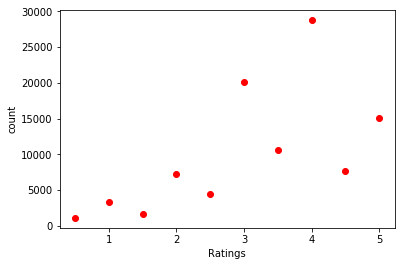

In [20]:
plt.plot(ratingsPD['rating'], ratingsPD['count'],'ro')
plt.xlabel('Ratings')
plt.ylabel('count')
plt.show()

### Thus, we see that people have given mostly 4 as the ratings followed by 3 and 5. People have shied way from giving lower ratings.

In [21]:
ratingsDF.count()

100004

In [22]:
ratingsDF.dropna().count()

100004

### In the above, we checked to see if there are any missing values in the rating DF. Since the count is same before and after using the drop missing values command, there are no missing values in the data.

In [23]:
ratings_count_per_userDF=ratingsDF.groupBy('user').count()

In [24]:
ratings_count_per_userDF.show()

+----+-----+
|user|count|
+----+-----+
|  26|  172|
|  29|   22|
| 474|   41|
|  65|   27|
| 191|   29|
| 418|  168|
| 541|   29|
| 558|  215|
| 222|   88|
| 270|  229|
| 293|   79|
| 243|  307|
| 278|   53|
| 367|  217|
| 442|  225|
|  19|  423|
|  54|   44|
| 296|   20|
| 277|   58|
| 287|  254|
+----+-----+
only showing top 20 rows



In [25]:
ratings_count_per_userDF.select('count').describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|               671|
|   mean|149.03725782414307|
| stddev|  231.226948245349|
|    min|                20|
|    max|              2391|
+-------+------------------+



### Thus, we have totl of 671 users giving us on average 149 ratings each with mximum number of movies rated  by a user of 2391 and minimum were 20. Earlier, we saw that these ratings vary from .5 to 5 in value.

### Let's see who are the top users and how many movies have they rated?

### Since we are going to do one more counting, let's change the column name from count to count_per_user to avoid confusion.

In [26]:
ratings_count_per_user_newDF= ratings_count_per_userDF.select("user", col("count").alias("count_per_user"))

In [27]:
ratings_count_per_user_newDF.show()

+----+--------------+
|user|count_per_user|
+----+--------------+
|  26|           172|
|  29|            22|
| 474|            41|
|  65|            27|
| 191|            29|
| 418|           168|
| 541|            29|
| 558|           215|
| 222|            88|
| 270|           229|
| 293|            79|
| 243|           307|
| 278|            53|
| 367|           217|
| 442|           225|
|  19|           423|
|  54|            44|
| 296|            20|
| 277|            58|
| 287|           254|
+----+--------------+
only showing top 20 rows



In [28]:
count_frequency=ratings_count_per_user_newDF.groupBy("count_per_user").count()

In [29]:
count_frequency.show()

+--------------+-----+
|count_per_user|count|
+--------------+-----+
|            29|    5|
|            26|    9|
|           191|    1|
|            65|    1|
|           222|    1|
|           367|    1|
|           278|    1|
|           296|    2|
|            54|    2|
|           113|    4|
|           299|    1|
|           155|    2|
|           385|    1|
|           347|    1|
|            22|   15|
|           198|    1|
|           196|    1|
|           487|    2|
|           130|    1|
|           427|    1|
+--------------+-----+
only showing top 20 rows



In the above, there are 2451 users who have rated 26 movies and so on.

In [30]:
count_frequency.sort("count_per_user").show()

+--------------+-----+
|count_per_user|count|
+--------------+-----+
|            20|   28|
|            21|   14|
|            22|   15|
|            23|   10|
|            24|    9|
|            25|   14|
|            26|    9|
|            27|   11|
|            28|    3|
|            29|    5|
|            30|    7|
|            31|   12|
|            32|    7|
|            33|    7|
|            34|    7|
|            35|    3|
|            36|    5|
|            37|    4|
|            38|   13|
|            39|   10|
+--------------+-----+
only showing top 20 rows



In [31]:
count_frequencyPD=count_frequency.toPandas()

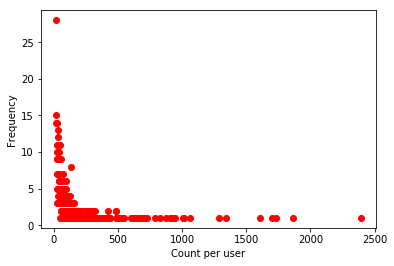

In [32]:
plt.plot(count_frequencyPD['count_per_user'],count_frequencyPD['count'],'ro')
plt.xlabel('Count per user')
plt.ylabel('Frequency')
plt.show()

### Thus we see that a large number of users have rated low number of movies and very few people have rated more than 100 movies. Sometimes, it may be good idea to treat them as outlier and remove them for consideration as such ratings could also have been generated by robots etc which will adversely affect our recommendations. However,  right now we will build a base recommendation model without considering such factors and leave them for further fine-tuning.

In [33]:
complete_ratings_data.take(5)

[(1, 31, 2.5), (1, 1029, 3.0), (1, 1061, 3.0), (1, 1129, 2.0), (1, 1172, 4.0)]

In [34]:
no_of_users= complete_ratings_data.map(lambda tokens:(int(tokens[0]))).distinct().count()

In [35]:
print "Total number of users in the ratings table are %d" % (no_of_users)

Total number of users in the ratings table are 671


In [36]:
no_of_movies=complete_ratings_data.map(lambda tokens:(int(tokens[1]))).distinct().count()

In [37]:
print "Total number of movies which are rated in the rating table are %d" % (no_of_movies)

Total number of movies which are rated in the rating table are 9066


### Let's calculate the density of the rating matrix or the fraction of the matrix which has ratings

In [38]:
density= float(float(no_of_ratings)/float((no_of_users*no_of_movies)))

In [39]:
print "The density of the rating matrix is %f" % density

The density of the rating matrix is 0.016439


### Thus, despite having a large number of ratings, we have only 1 out of 500 cell with some rating value. This is very typical of rating matrices. They are very sparse and hence traditional prediciton methods do not work. The objective of the recommendation calculations is to use each of the these 1 out of 500 values to get the estimate of other 499 values. Collaborative filtering is a systematic way to do just that.

## Total movies

In [40]:
complete_movies_header = complete_movies_raw_data.take(1)[0]

In [41]:
complete_movies_data = complete_movies_raw_data.filter(lambda l: l!=complete_movies_header)\
    .map(lambda l: l.split(",")).map(lambda tokens: (int(tokens[0]),tokens[1])).cache()

In [42]:
complete_movies_data.take(5)

[(1, u'Toy Story (1995)'),
 (2, u'Jumanji (1995)'),
 (3, u'Grumpier Old Men (1995)'),
 (4, u'Waiting to Exhale (1995)'),
 (5, u'Father of the Bride Part II (1995)')]

In [43]:
complete_movies_data.count()

9125

### Total movies in the dataset are 40110 while 39443 movies are there in the ratings data. Thus, we have ratings for a large fraction of the movies which are there in the movies table.

## Divide the data in training and testing part in the ratio 75:25

In [44]:
complete_ratings_data.take(5)

[(1, 31, 2.5), (1, 1029, 3.0), (1, 1061, 3.0), (1, 1129, 2.0), (1, 1172, 4.0)]

In [45]:
training, test = complete_ratings_data.randomSplit([8.0, 2.0], seed=100)

In [46]:
training.count()

80088

In [47]:
test.take(5)

[(1, 1029, 3.0),
 (1, 1061, 3.0),
 (1, 1405, 1.0),
 (1, 2105, 4.0),
 (1, 2193, 2.0)]

### Set the parameters of Alternating Least Square method for model building

In [ ]:
seed= 100
rank = 3 
numIterations = 1 #How many times will be iterate over the data
lmbda = 0.2

## Train the model

In [ ]:
model = ALS.train(training, rank, numIterations, seed=seed)

In [49]:
model.productFeatures().count()

8380

In [50]:
model.productFeatures().take(1)

[(16,
  array('d', [3.0829007625579834, -0.6575445532798767, 0.891096830368042]))]

In [54]:
productDimension1 = model.productFeatures().map(lambda x: x[1][1]).collect()

In [56]:
productDimension2 = model.productFeatures().map(lambda x: x[1][2]).collect()

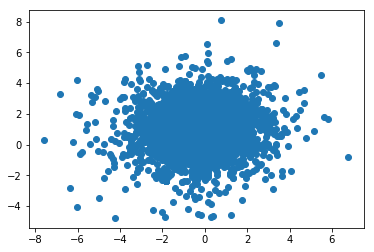

In [57]:
plt.scatter(productDimension1, productDimension2)
plt.show()

In [58]:
model.userFeatures().count()

671

In [59]:
predict_train = training.map(lambda x: (x[0], x[1]))

## Prediction on training data to check the model accuracy

In [60]:
predictAllOutput = model.predictAll(predict_train).map(lambda r: ((r[0], r[1]), r[2]))

### Prediction for first user of training set

In [61]:
predictAllOutput.first()

((529, 3456), 3.514260843602914)

### Join all actual and predicted ratings for training set

In [62]:
ratings_and_preds= training.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictAllOutput)

### Check actual vs predicted ratings for first five users

In [63]:
ratings_and_preds.take(5)

[((600, 588), (5.0, 4.29423138813546)),
 ((282, 2968), (4.5, 2.8778658804993924)),
 ((177, 1515), (4.0, 3.5551074883878693)),
 ((468, 55830), (1.5, 2.4015038525233297)),
 ((525, 3489), (3.0, 3.9036201682471017))]

In [64]:
t=ratings_and_preds.take(1)

In [65]:
t[0][1][1]

4.29423138813546

### Evaluate training model

In [66]:
t1=ratings_and_preds.map(lambda r: (r[1][0]-r[1][1])**2)

In [67]:
type(t1)

pyspark.rdd.PipelinedRDD

In [68]:
t1.first()

0.49810933349320013

In [69]:
t1.count()

80088

In [70]:
MSE_valid = ratings_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()

In [71]:
MSE_valid

0.48000612015533795

In [72]:
rmse_valid = np.sqrt(MSE_valid)

In [73]:
rmse_valid

0.69282473985513682

## Prediction on Test Data

In [74]:
predict_test = test.map(lambda x: (x[0], x[1]))

In [75]:
predictAllOutput1 = model.predictAll(predict_test).map(lambda r: ((r[0], r[1]), r[2]))

In [76]:
predictAllOutput1.first()

((547, 6400), 4.0375213602506275)

In [77]:
ratings_and_preds1= test.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictAllOutput1)

In [78]:
ratings_and_preds1.take(5)

[((75, 1127), (3.0, 4.174172367232146)),
 ((463, 593), (5.0, 3.9709297901329967)),
 ((452, 2716), (4.0, 3.4596241646330252)),
 ((378, 8376), (3.5, 4.177317980375511)),
 ((61, 6377), (3.0, 3.670672787065712))]

### Model Evaluation

In [79]:
MSE = ratings_and_preds1.map(lambda r: (r[1][0] - r[1][1])**2).mean()

In [80]:
MSE

0.9963879272364008

In [81]:
rmse = np.sqrt(MSE)

In [82]:
rmse

0.99819232978239258

### If you want to generate the top recommendations for one user use recommendProducts()

### Recommend top products to user

In [106]:
recomm = model.recommendProducts(61, 10)

In [107]:
recMovie1 = set(recomm)

In [108]:
recMovie1

{Rating(user=61, product=1162, rating=13.64908388026732),
 Rating(user=61, product=3490, rating=12.29210112135939),
 Rating(user=61, product=3520, rating=13.369085901280236),
 Rating(user=61, product=3813, rating=10.764231877745875),
 Rating(user=61, product=4146, rating=11.497418630789745),
 Rating(user=61, product=4396, rating=11.720154386807117),
 Rating(user=61, product=7577, rating=11.430945153255742),
 Rating(user=61, product=8574, rating=11.10448322733076),
 Rating(user=61, product=45837, rating=10.729646542257967),
 Rating(user=61, product=70533, rating=10.919132778535024)}

In [114]:
def MovieNames(line):
    if line[0] in [recomm[i][1] for i in range(len(recomm))]:
        return True
    else:
        return False

recList1 =complete_movies_data.filter(lambda line: MovieNames(line)).values().collect()
print(recList1)

[u'"Ruling Class', u'Horror Express (1972)', u'How to Stuff a Wild Bikini (1965)', u'Interiors (1978)', u'"Million Dollar Hotel', u'"Cannonball Run', u'"Magic Flute', u'"Claymation Christmas Celebration', u'Let It Be (1970)', u'Evangelion: 1.0 You Are (Not) Alone (Evangerion shin gekij\xf4ban: Jo) (2007)']


#### Given a product id and a number of users (N), recommendUsers will find the top N users for the product id. This is a great tool for companies who are product-first focused.

In [115]:
id100RecoUsers100 = model.recommendUsers(1162, 100)

In [116]:
type(id100RecoUsers100)

list

In [117]:
id100RecoUsers100[0:10]

[Rating(user=410, product=1162, rating=24.297577307643802),
 Rating(user=207, product=1162, rating=21.14799198651635),
 Rating(user=337, product=1162, rating=20.611675572428048),
 Rating(user=364, product=1162, rating=19.90596534965941),
 Rating(user=484, product=1162, rating=18.889736053822347),
 Rating(user=63, product=1162, rating=18.412453847520133),
 Rating(user=670, product=1162, rating=18.21771097438836),
 Rating(user=645, product=1162, rating=17.166432839321324),
 Rating(user=29, product=1162, rating=16.963137282344896),
 Rating(user=58, product=1162, rating=16.591427677318052)]